# Audiobooks business case

## Visualiza the data. Preprocess the data. Balance the dataset. Create 3 datasets: training, validation, and test. Save the newly created sets in a tensor friendly format (e.g. *.npz)

Since we are dealing with real life data, we will need to preprocess it a bit.

Note that we have removed the header row, which contains the names of the categories for the preprocessing part. We simply want the data.

### Extract the data from the csv for visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [2]:
raw_csv_data_vis = pd.read_csv('Audiobooks_data.csv', delimiter=',')
colls = ['ID', 'Book length (mins)_overall', 'Book length (mins)_avg', 'Price_overall', 'Price_avg', 'Review', 
         'Review 10/10', 'Minutes listened', 'Completion', 'Support Requests', 'Last visited minus Purchase date', 'Targets']
raw_csv_data_vis.columns = colls
raw_csv_data_vis.head()

,ID,Book length (mins)_overall,Book length (mins)_avg,Price_overall,Price_avg,Review,Review 10/10,Minutes listened,Completion,Support Requests,Last visited minus Purchase date,Targets
0,1143,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0,0
1,2059,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388,0
2,2882,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129,0
3,3342,2160.0,2160,5.33,5.33,0,8.91,0.22,475.2,0,361,0
4,3416,2160.0,2160,4.61,4.61,0,8.91,0.00,0.0,0,0,0


### Basic visualization

#### Histogram for Book Length (mins)_overall and Book Length (mins)_avg

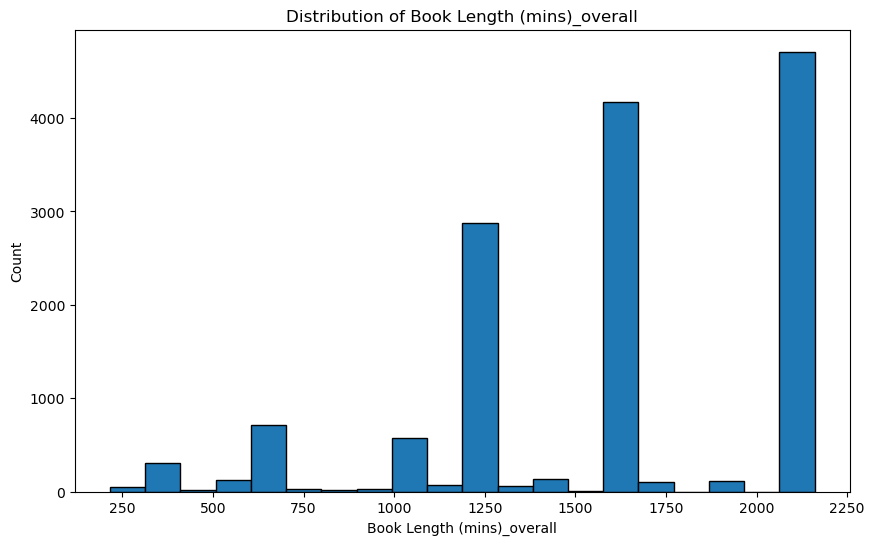

In [3]:
# Histogram for Book Length (mins)_overall
plt.figure(figsize=(10, 6))
plt.hist(raw_csv_data_vis['Book length (mins)_overall'], bins=20, edgecolor='black')
plt.title('Distribution of Book Length (mins)_overall')
plt.xlabel('Book Length (mins)_overall')
plt.ylabel('Count')
plt.show()

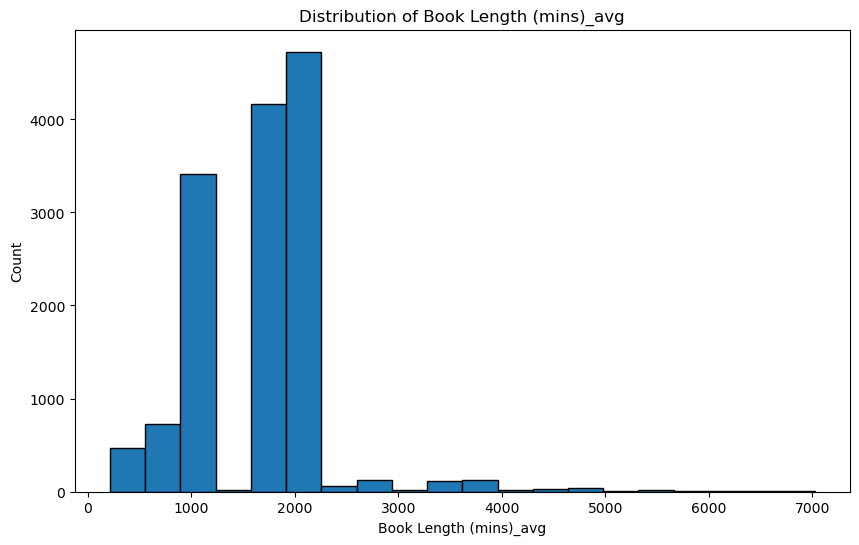

In [4]:
# Histogram for Book Length (mins)_avg
plt.figure(figsize=(10, 6))
plt.hist(raw_csv_data_vis['Book length (mins)_avg'], bins=20, edgecolor='black')
plt.title('Distribution of Book Length (mins)_avg')
plt.xlabel('Book Length (mins)_avg')
plt.ylabel('Count')
plt.show()

#### Scatter Plot for Price_overall vs. Book Length (mins)_overall

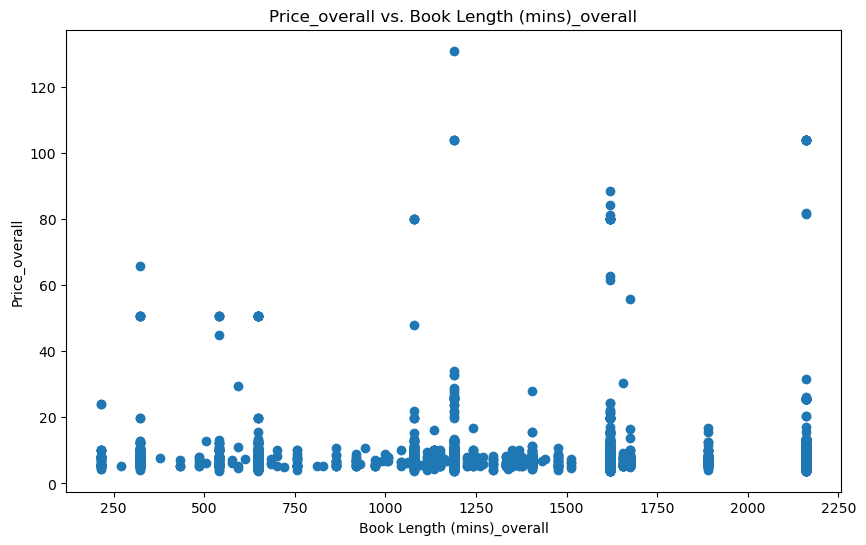

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(raw_csv_data_vis['Book length (mins)_overall'], raw_csv_data_vis['Price_overall'])
plt.title('Price_overall vs. Book Length (mins)_overall')
plt.xlabel('Book Length (mins)_overall')
plt.ylabel('Price_overall')
plt.show()

#### Pie Chart for Targets

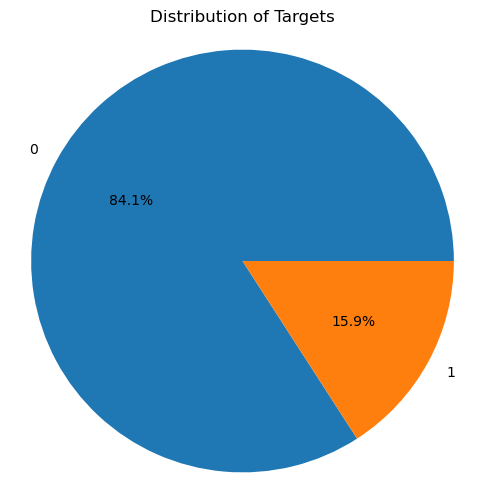

In [6]:
plt.figure(figsize=(6, 6))
plt.pie(raw_csv_data_vis['Targets'].value_counts(), labels=['0', '1'], autopct='%1.1f%%')
plt.title('Distribution of Targets')
plt.axis('equal')
plt.show()

### Extract the data from the csv

In [7]:
raw_csv_data = np.loadtxt('Audiobooks_data.csv', delimiter=',')

unscaled_inputs_all = raw_csv_data[:, 1:-1]
targets_all = raw_csv_data[:, -1]

### Feature engineering

Create a new feature 'listen_ratio'

In [8]:
unscaled_inputs_all = np.column_stack((unscaled_inputs_all, 
                                       unscaled_inputs_all[:, 7] / unscaled_inputs_all[:, 2]))

Categorical Encoding: The 'Review' column is a Boolean variable, which can be treated as a categorical feature. We will perform one-hot encoding on this column to convert it into a numerical format that can be used by the model.

In [9]:
categorical_features = unscaled_inputs_all[:, [5]]
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_features_encoded = one_hot_encoder.fit_transform(categorical_features)

unscaled_inputs_all = np.column_stack((unscaled_inputs_all[:, :5], 
                                       categorical_features_encoded.toarray(), 
                                       unscaled_inputs_all[:, 6:]))

### Shuffle the data

We shuffle the indices before balancing (to remove any day effects, etc.)

However, we still have to shuffle them AFTER we balance the dataset as otherwise, all targets that are 1s will be contained in the train_targets.

In [10]:
# shuffled_indices = np.arange(unscaled_inputs_all.shape[0])
# np.random.shuffle(shuffled_indices)

# unscaled_inputs_all = unscaled_inputs_all[shuffled_indices]
# targets_all = targets_all[shuffled_indices]

### Balance the dataset

In [11]:
num_one_targets = int(np.sum(targets_all))
zero_targets_counter = 0

indices_to_remove = []

for i in range(targets_all.shape[0]):
    if targets_all[i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)

unscaled_inputs_equal_priors = np.delete(unscaled_inputs_all, indices_to_remove, axis=0)
targets_equal_priors = np.delete(targets_all, indices_to_remove, axis=0)

### Shuffle the data

In [12]:
shuffled_indices = np.arange(unscaled_inputs_equal_priors.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs = unscaled_inputs_equal_priors[shuffled_indices]
shuffled_targets = targets_equal_priors[shuffled_indices]

### Split the dataset into train, validation, and test

In [13]:
samples_count = shuffled_inputs.shape[0]

train_samples_count = int(0.9 * samples_count)
validation_samples_count = int(0.05 * samples_count)
test_samples_count = samples_count - train_samples_count - validation_samples_count

train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

test_inputs = shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets = shuffled_targets[train_samples_count+validation_samples_count:]

# Print the number of targets that are 1s, the total number of samples, and the proportion for training, validation, and test.
print('Train:', '1 -', np.sum(train_targets), '  Total -', train_samples_count, '  Proportion -', np.sum(train_targets) / train_samples_count)
print('Validation:', '1 -', np.sum(validation_targets), '  Total -', validation_samples_count, '  Proportion -', np.sum(validation_targets) / validation_samples_count)
print('Test: ', '1 -', np.sum(test_targets), '  Total -', test_samples_count, '  Proportion -', np.sum(test_targets) / test_samples_count)

Train: 1 - 2016.0   Total - 4026   Proportion - 0.5007451564828614
Validation: 1 - 108.0   Total - 223   Proportion - 0.484304932735426
Test:  1 - 113.0   Total - 225   Proportion - 0.5022222222222222


### Standardize the inputs

In [14]:
train_inputs = preprocessing.scale(train_inputs)
validation_inputs = preprocessing.scale(validation_inputs)
test_inputs = preprocessing.scale(test_inputs)

### Save the three datasets in *.npz

In [15]:
np.savez('Audiobooks_data_train', inputs=train_inputs, targets=train_targets)
np.savez('Audiobooks_data_validation', inputs=validation_inputs, targets=validation_targets)
np.savez('Audiobooks_data_test', inputs=test_inputs, targets=test_targets)